Imports

In [1]:
import pysmurf.client
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import epics
import os

%matplotlib inline

Instantiate pysmurf

In [2]:
epics_prefix = "smurf_server_s2"
config_file  = "/usr/local/src/pysmurf/cfg_files/mit/experiment_mit.cfg"
S = pysmurf.client.SmurfControl(epics_root=epics_prefix, cfg_file=config_file, setup=False, make_logfile=False)

Set a fixed tone off resonance at 4.250 GHz.

In [3]:
S.all_off()
(band,channel)=S.set_fixed_tone(4250,12)

[ 2021-10-16 07:32:48 ]  Turning off tones
[ 2021-10-16 07:32:53 ]  Turning off flux ramp
[ 2021-10-16 07:32:53 ]  Turning off all TES biases


Returns (band,channel).  Now calibrate eta;

In [5]:
S.run_serial_eta_scan(0)
print(f'b0ch0 eta_phase_deg={S.get_eta_phase_degree_channel(0,0)}')

b0ch0 eta_phase_deg=-71.96648775440947


Serial eta scan enables feedback, so even though we instantiated this as a fixed tone, need to disable it's feedback again.

In [7]:
S.set_feedback_enable_channel(band,channel,0)

Take I/Q noise.

In [8]:
nsamp=2**20

# Quadrature noise
fq, dfq, syncq = S.take_debug_data(band=band, channel=channel, nsamp=nsamp, IQstream=0, single_channel_readout=2)
tq = np.arange(len(dfq))/(1.e6*S.get_channel_frequency_mhz(band))

# Rotate into the other quadrature.
qetaPhaseDegree=S.get_eta_phase_degree_channel(band=band,channel=channel)
def etaPhaseModDegree(etaPhase):
    return (etaPhase+180)%360-180
# Rotating by 90 to get inphase 
S.set_eta_phase_degree_channel(band=band,channel=channel,val=etaPhaseModDegree(qetaPhaseDegree+90))

# Quadrature noise
fi, dfi, synci = S.take_debug_data(band=band, channel=channel, nsamp=nsamp, IQstream=0, single_channel_readout=2)
ti = np.arange(len(dfi))/(1.e6*S.get_channel_frequency_mhz(band))

[ 2021-10-16 07:33:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2021-10-16 07:33:33 ]  Writing to file : /data/smurf_data/20211016/1634369564/outputs/1634369614.dat
[ 2021-10-16 07:33:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 1048576
[ 2021-10-16 07:33:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2021-10-16 07:33:33 ]  Data acquisition in progress...
[ 2021-10-16 07:33:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-10-16 07:33:36 ]  Done taking data
[ 2021-10-16 07:33:36 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2021-10-16 07:33:36 ]  Writing to file : /data/smurf_data/20211016/1634369564/outputs/1634369616.dat
[ 2021-10-16 07:33:36 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 1048576
[ 2021-10-16 07:33:36 ]  caput smurf_server

Compute power spectral densities relative to carrier.

In [9]:
meaniq=np.mean(np.mean(dfi)**2 + np.mean(dfq)**2)
print(meaniq)

ffi,pxxi=signal.welch(dfi, nperseg=len(fi)/8., fs=1.0E6*S.get_channel_frequency_mhz(band))
ffq,pxxq=signal.welch(dfq, nperseg=len(fq)/8., fs=1.0E6*S.get_channel_frequency_mhz(band))

2.1376423530685584


Plot power spectral densities in dBc/Hz

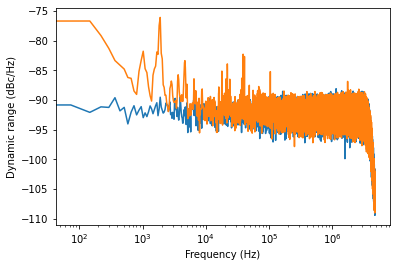

In [11]:
plt.semilogx(ffi,10.*np.log10(pxxi/meaniq))
plt.semilogx(ffq,10.*np.log10(pxxq/meaniq))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Dynamic range (dBc/Hz)')

plt.show()

Alternate method ; rfIQ mode.

In [12]:
i2,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp)

[ 2021-10-16 07:34:55 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2021-10-16 07:34:55 ]  Writing to file : /data/smurf_data/20211016/1634369564/outputs/1634369695.dat
[ 2021-10-16 07:34:55 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 1048576
[ 2021-10-16 07:34:55 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2021-10-16 07:34:55 ]  Data acquisition in progress...
[ 2021-10-16 07:34:55 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-10-16 07:34:57 ]  Done taking data


Not sure about the rotation.  Need to check.

In [13]:
eta_phase = S.get_eta_phase_degree_channel(band, channel)
eta_phase_rad = np.deg2rad(eta_phase)
I = np.cos(eta_phase_rad) * i2 - np.sin(eta_phase_rad) * q
Q = np.sin(eta_phase_rad) * i2 + np.cos(eta_phase_rad) * q

ffi,pxxi = signal.welch(I,fs=1.e6*S.get_channel_frequency_mhz(band),nperseg=len(i2)/8)
ffq,pxxq = signal.welch(Q,fs=1.e6*S.get_channel_frequency_mhz(band),nperseg=len(i2)/8)

(1000.0, 10000.0)

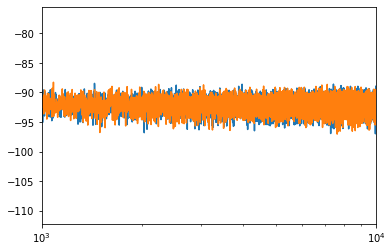

In [15]:
magfac = np.mean(q)**2 + np.mean(i2)**2
pxxi_dbc = 10. * np.log10(pxxi / magfac)
pxxq_dbc = 10. * np.log10(pxxq / magfac)

plt.semilogx(pxxi_dbc)
plt.semilogx(pxxq_dbc)

plt.xlim(1e3,1e4)